# MNIST Classifier with PyTorch framework

* Based on http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* Anton Karazeev, you can text me: [```anton.karazeev@gmail.com```](mailto:anton.karazeev@phystech.edu) or [t.me/akarazeev](https://t.me/akarazeev)

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# Download MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Processing...
Done!


(32, 122, 3)
    2     7     7     4


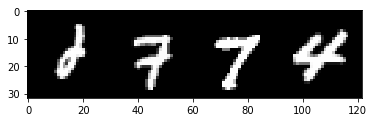

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print(np.transpose(npimg, (1, 2, 0)).shape)
    
# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Training

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## Network definition

In [6]:
# Define our net's class
class Net(nn.Module):
    def __init__(self):
        # Hint: things like `print(self.conv1(x).size())` in `forward()`
        # can help you to find correct layers' parameters
        super(Net, self).__init__()
        
        # set <in_channels>, <out_channels>, <kernel_size>
        self.conv1 = nn.Conv2d(1, 16, 3)
        
        # set <kernel_size> and <stride> here
        self.pool = nn.MaxPool2d(3, stride=1)
        
        # set correct <input_size> here
        # it equals to (Height * Width * 'Number of channels')
        self.fc1 = nn.Linear(24 * 24 * 16, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

## Choose loss function

Use [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy) as a loss function: $H(p,q)=-\sum_i p_i \cdot \log(q_i)$, where $p_i$ - true label, $q_i$ - prediction.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# set <learning_rate> and <momentum> here
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(net.parameters(), learning_rate, momentum)

## Let's train our net

In [8]:
num_epochs = 2

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data

        # Wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward -> backward -> optimize
        outputs = net(inputs)
        if i == 0:
            print(type(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

<class 'torch.autograd.variable.Variable'>
[1,  2000] loss: 0.530
[1,  4000] loss: 0.303
[1,  6000] loss: 0.270
[1,  8000] loss: 0.270
[1, 10000] loss: 0.299
[1, 12000] loss: 0.370
[1, 14000] loss: 0.304
<class 'torch.autograd.variable.Variable'>
[2,  2000] loss: 0.243
[2,  4000] loss: 0.244
[2,  6000] loss: 0.256
[2,  8000] loss: 0.221
[2, 10000] loss: 0.269
[2, 12000] loss: 0.276
[2, 14000] loss: 0.274
Finished Training


# Testing the network

## Ground Truth

(32, 122, 3)
GroundTruth:      7     2     1     0


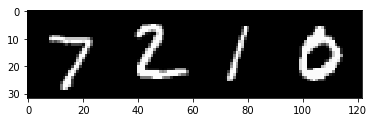

In [9]:
# Get some random testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Prediction

Higher the energy for a class - the more net thinks that the image is of a particular class.

In [10]:
outputs = net(Variable(images))
outputs  # Energies for every class

Variable containing:

Columns 0 to 7 
 -8.4808  -3.6334  -1.9637   6.0696  -5.5748   0.3131 -14.0798  26.0916
 -3.9777   2.1464  16.4529   3.4583  -4.3915  -3.3023  -0.9127   0.7092
 -1.7604  12.3916  -2.0086  -4.2657   1.2392  -0.4663  -0.0890  -0.7883
 13.4387  -4.7319  -1.4404  -3.5476  -1.4489  -1.1305   1.2957  -0.8624

Columns 8 to 9 
 -5.0882   5.9803
 -3.3665  -5.8767
 -1.7695  -2.6385
 -1.9316   1.1819
[torch.FloatTensor of size 4x10]

So we should get the index of maximum energy for every image.

In [11]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[int(predicted[j].numpy())]
                              for j in range(4)))

Predicted:      7     2     1     0


## Measure the Accuracy

In [12]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))            # Prediction
    _, predicted = torch.max(outputs.data, 1)  # Indices of max energies
    total += labels.size(0)                    # Number of samples in `data`
    correct += (predicted == labels).sum()     # Number of right predictions

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


## Accuracy for every class

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %2s is %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  0 is 98 %
Accuracy of  1 is 99 %
Accuracy of  2 is 96 %
Accuracy of  3 is 92 %
Accuracy of  4 is 91 %
Accuracy of  5 is 91 %
Accuracy of  6 is 95 %
Accuracy of  7 is 90 %
Accuracy of  8 is 91 %
Accuracy of  9 is 96 %
